In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from config_images import *
import matplotlib.gridspec as gridspec

In [2]:
#save_path = "/home/labic/Projects/Alerce/datasets/simulated_data/image_sequences"
save_path = "../../datasets/simulated_data/image_sequences/good_zero_points_good_zero_points10"
f = h5py.File(save_path+".hdf5", "r")
fields = list(f.keys())
#stats = np.load("/home/toshiba/rodrigo/simulated_lightcurves/multiclass_SNLS_short20000.pkl")

In [3]:
list(f.keys()) # ['Field01', 'Field02', 'Field03', 'Field04' ...]
list(f["Field01"].keys())
"""['count_lightcurves',
 'galaxy_flag',
 'galaxy_image',
 'ids',
 'images',
 'labels',
 'lc_type',
 'lightcurves',
 'obs_cond',
 'psf_image']"""
data_keys = ['count_lightcurves',
 'galaxy_flag',
 'galaxy_image',
 'ids',
 'images',
 'labels',
 'lc_type',
 'lightcurves',
 'obs_cond',
 'psf_image']
list(f["Field01"]["images"].keys())

['g', 'r']

In [4]:
list(f["Field01"]['obs_cond'].keys())

['airmass',
 'epoch',
 'exp_time',
 'filter',
 'flux_conversion',
 'good_quality_points',
 'limmag3',
 'limmag5',
 'obs_day',
 'seeing',
 'sky_brightness',
 'zero_point']

In [5]:
#f["Field01"]['lightcurves']['g'][0]

In [6]:
f["Field01"]['estimated_counts']['g']

<HDF5 dataset "g": shape (60, 11), type "<f8">

In [7]:
def print_shape(f, data_keys, n_fields = 5, bands = ["g", "r"]):
    fields = list(f.keys())
    for field in fields[:n_fields]:
        print("Field", field)
        #data_keys = list(f[field].keys())
        for k in data_keys:
            for b in bands:
                print("key:",k," band:", b)
                if k not in ["galaxy_flag", "ids", "labels", "lc_type", "obs_cond"]:
                    print(f[field][k][b].shape)
                elif k == "obs_cond":
                    k_keys = list(f[field][k].keys())
                    for k_obs in k_keys:
                        if k_obs in ["filter", "limmag3"]:
                            continue
                        print("obs_cond", k_obs)
                        print(f[field][k][k_obs][b].shape)
                else:
                    continue
                    #print(f[field][k].shape)
#print_shape(f, data_keys)

In [8]:
estimated_counts_key = 'estimated_counts'
estimated_error_counts_key = 'estimated_error_counts'
g_key = 'g'
r_key = 'r'
lightcurves_key = 'lightcurves'#'count_lightcurves'#

def get_magnitude_error(estimated_counts, estimated_count_error):
  f = estimated_counts
  sigma_f = np.sqrt(estimated_count_error)
  sigma_m = 1.09 * (sigma_f / f)
  return sigma_m


def get_magnitude(ADU, zp, T):
  print(zp[:])
  magnitude = zp - 2.5 * np.log10(ADU)# / T)
  #if np.isnan(magnitude).any():
  #  print("ADU %s\nT %s\nADU/T %s\nlog %s"
  #        % (str(ADU), str(T), str(ADU / T), str(np.log10(ADU / T))))
  return magnitude

def _silent_plot_lc(ax, field_data, lc_idx, plt_marker='o-'):
  field_lc = field_data[lightcurves_key]
  estimated_counts = field_data[estimated_counts_key]
  estimated_error_counts = field_data[estimated_error_counts_key]
  days = field_data["obs_cond"]["obs_day"]
  bands = list(field_data[lightcurves_key].keys())
  colors = ['y', 'r']
  for i, band in enumerate(bands):
    zp = field_data["obs_cond"]['zero_point'][band][:]
    magnitude_noisy = get_magnitude(estimated_counts[band][lc_idx], zp, 30)#estimated_counts[band][lc_idx]#
    magnitude_error = get_magnitude_error(estimated_counts[band][lc_idx],
                                          estimated_error_counts[band][lc_idx])
    # print(estimated_counts[band][lc_idx].shape)
    # print(magnitude_error)
    # print(days[band])
    # print(magnitude_noisy)
    #c
    ax.plot(days[band], field_lc[band][lc_idx], '%s%s'%(colors[i],plt_marker), label='%s; model' % band)#,
        #color=color)
    color = ax.get_lines()[i * 2].get_color()
    ax.errorbar(days[band][:], magnitude_noisy, yerr=magnitude_error, fmt='o--',
                label='%s; lightcurve' % band, color=color)
    ax.set_ylim([21, 15])
    #plt.gca().invert_yaxis()

  ax.legend()
  galaxy_flag = field_data["galaxy_flag"][lc_idx]
  lc_type = field_data["lc_type"][lc_idx]
  ax.set_title("%s; galaxy_flag: %i" % (lc_type, galaxy_flag), fontsize=15)
  return ax


def _get_field(data, field):
  if field is None:
    fields = list(data.keys())
    field = fields[int(np.random.choice(np.arange(len(fields)), 1, replace=False))]
    return field
  else:
    return field

def plot_underliying_and_lc_model(data, field=None, n_to_plot=1):
    field = _get_field(data, field)
    field_data = data[field]
    lc_idxs_to_plot = np.random.choice(np.arange(field_data[lightcurves_key][g_key].shape[0]), n_to_plot, replace=False) #[13]
    print('%s%s' % (field, str(lc_idxs_to_plot)))
    plt.close()
    for lc_idx in lc_idxs_to_plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
        _silent_plot_lc(ax, field_data, lc_idx)
        
        #plt.close()
    plt.show()
    return lc_idxs_to_plot[0]


Field01
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 11) r: (60, 21, 21, 12)
lcs g: (60, 11) r: (60, 12)
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (12,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">

Field02
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 16) r: (60, 21, 21, 4)
lcs g: (60, 16) r: (60, 4)
obs days <HDF5 dataset "g": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 16), type "<f8">
obs days <HDF5 dataset "r": shape (4,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 4), type "<f8">
Fi

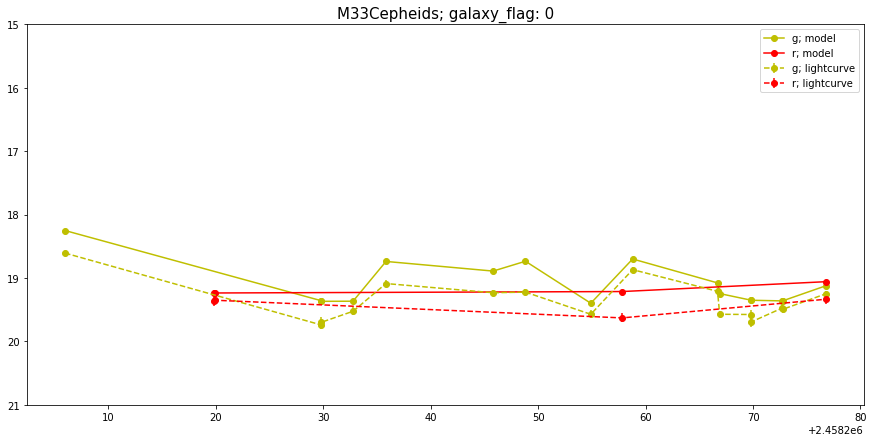

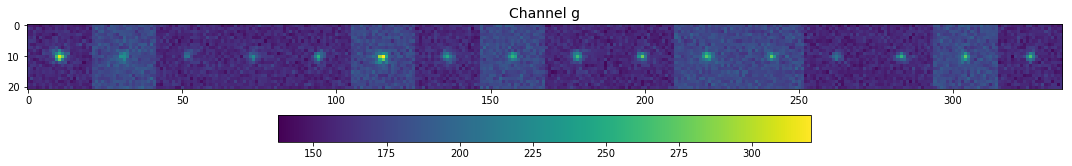

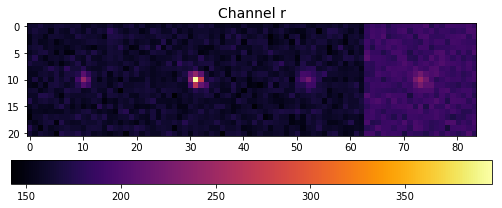


Field03
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 17) r: (60, 21, 21, 19)
lcs g: (60, 17) r: (60, 19)
obs days <HDF5 dataset "g": shape (17,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 17), type "<f8">
obs days <HDF5 dataset "r": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 17), type "<f8">

Field04
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 5) r: (60, 21, 21, 25)
lcs g: (60, 5) r: (60, 25)
obs days <HDF5 dataset "g": shape (5,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 5), type "<f8">
obs days <HDF5 dataset "r": shape (25,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 5), type "<f8">

Fi

/home/ereyes/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


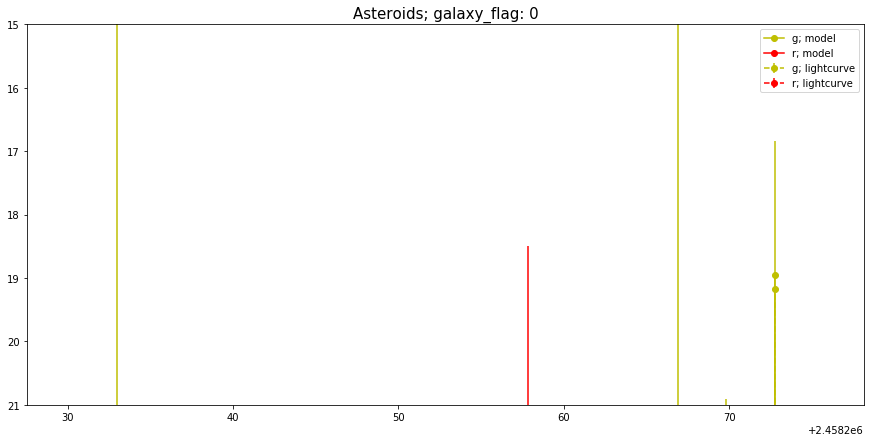

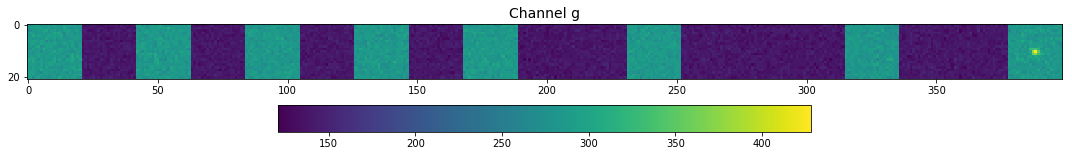

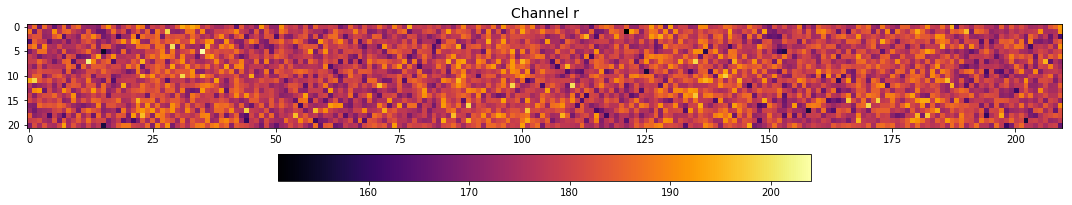


Field06
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 105) r: (60, 21, 21, 14)
lcs g: (60, 105) r: (60, 14)
obs days <HDF5 dataset "g": shape (105,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 105), type "<f8">
obs days <HDF5 dataset "r": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 14), type "<f8">
Field06[38]
[26.49650502 26.41891146 26.4181397  26.42920446 27.02239132 26.56259894
 26.40330887 26.61541867 26.33381248 26.33576608 26.33756232 26.33562708
 26.33538675 26.33991933 26.335958   26.33759403 26.33677983 26.33782315
 26.49451113 26.50523996 26.50394034 26.41556787 26.33560824 26.52312899
 26.56964827 26.55583596 26.61603594 26.53200102 26.5182662  26.59484959
 26.56937933 26.54247451 26.48843026 26.50660062 26.5925231  26.49123025
 26.55028868 26.42588115 26.54895878 26.50309

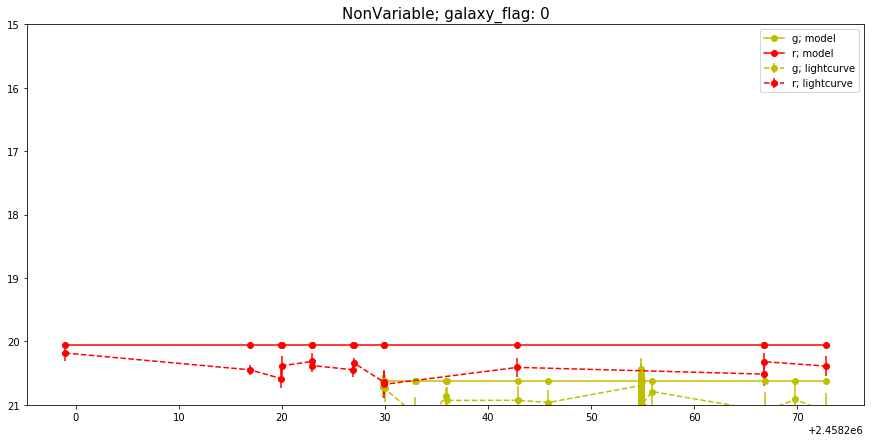

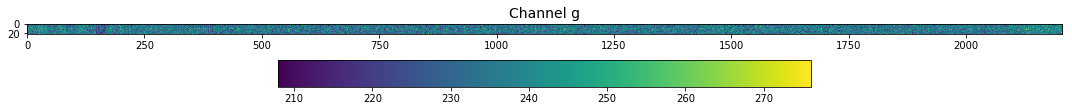

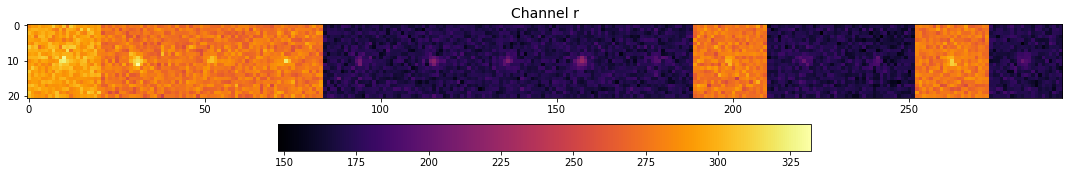


Field07
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 91) r: (60, 21, 21, 8)
lcs g: (60, 91) r: (60, 8)
obs days <HDF5 dataset "g": shape (91,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 91), type "<f8">
obs days <HDF5 dataset "r": shape (8,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 8), type "<f8">
Field07[26]
[26.99594188 26.42073298 25.9951458  26.45375466 26.5155158  26.65938997
 26.23008168 26.40487111 26.28420019 26.27019119 26.31381059 26.25532138
 26.28633881 26.24055171 26.33700895 26.2704798  26.29208958 26.30112696
 26.30781913 26.27325904 26.35433173 26.49340665 26.34711862 26.39399314
 26.38711131 26.28205144 26.27369428 26.32164967 26.40734529 26.40176284
 26.43722057 26.36249018 26.4349556  26.39869332 26.33381712 26.37106776
 26.37398493 26.30433834 26.30962539 26.21857512 26.2

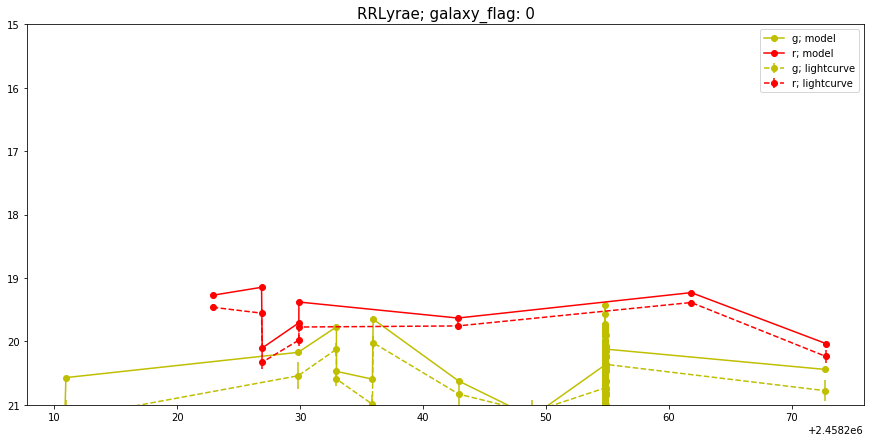

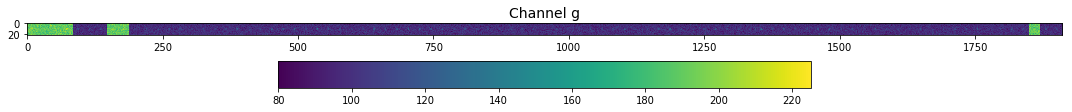

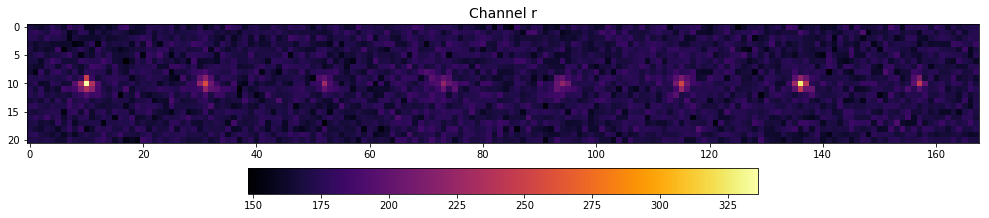


Field08
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 11) r: (60, 21, 21, 20)
lcs g: (60, 11) r: (60, 20)
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (20,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">

Field09
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 13) r: (60, 21, 21, 11)
lcs g: (60, 13) r: (60, 11)
obs days <HDF5 dataset "g": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 13), type "<f8">
obs days <HDF5 dataset "r": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8"

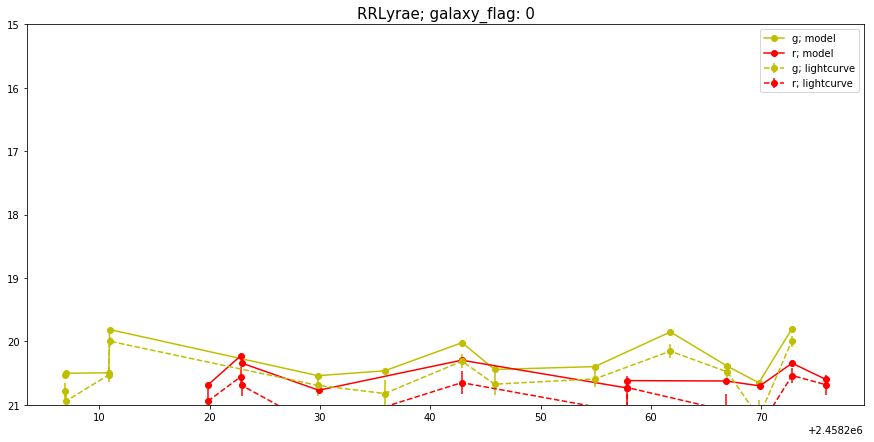

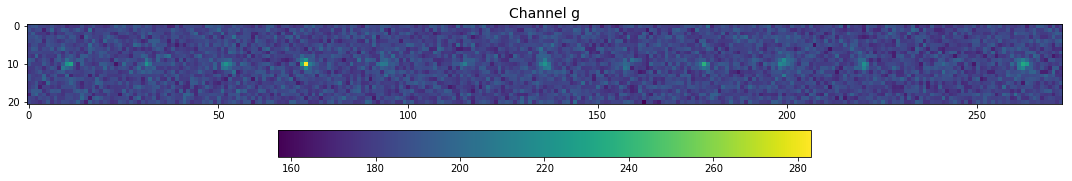

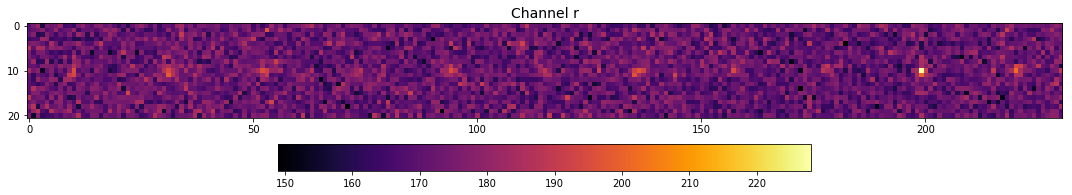


Field10
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 20) r: (60, 21, 21, 14)
lcs g: (60, 20) r: (60, 14)
obs days <HDF5 dataset "g": shape (20,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 20), type "<f8">
obs days <HDF5 dataset "r": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 14), type "<f8">
Field10[52]
[26.28825331 26.80556393 26.15838313 26.19257379 26.08623612 26.41730893
 26.53821588 25.76427257 26.63704598 26.60256267 26.14522469 26.34882271
 26.15043819 26.43432188 26.30002654 26.36313605 26.38170457 26.57368255
 26.30550718 26.38543308]
[26.19711983 26.43221879 26.50461853 26.05596542 26.86675549 26.9413166
 26.58708036 26.29746068 26.2804358  26.24495411 26.23238969 26.33258545
 26.34264934 26.2444551 ]


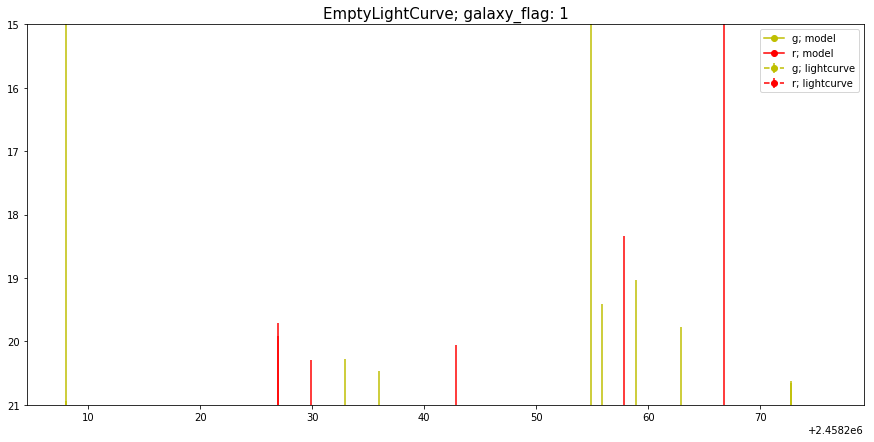

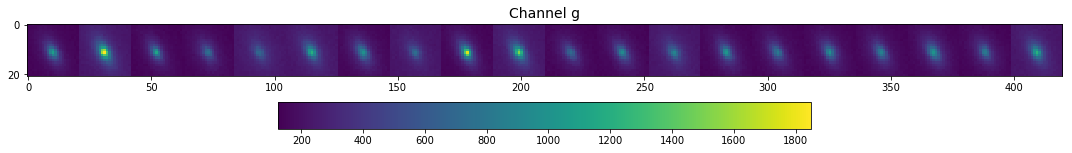

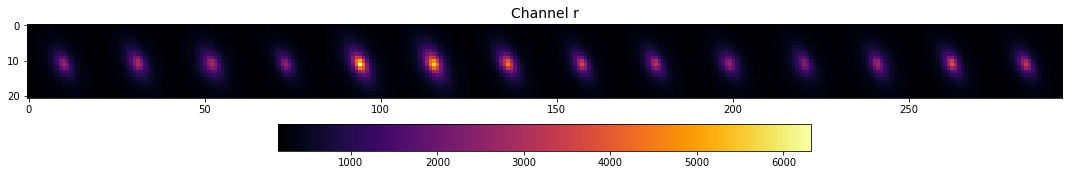


Field11
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 13) r: (60, 21, 21, 7)
lcs g: (60, 13) r: (60, 7)
obs days <HDF5 dataset "g": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 13), type "<f8">
obs days <HDF5 dataset "r": shape (7,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 7), type "<f8">
Field11[8]
[26.41345    26.37969887 26.27755094 26.52501595 26.33982611 26.24804068
 26.56022704 26.5188427  26.62773228 26.26230884 26.33424568 26.41764712
 26.25804007]
[26.41750801 26.2782346  26.34014273 26.36979854 26.27827346 26.31590903
 26.307096  ]


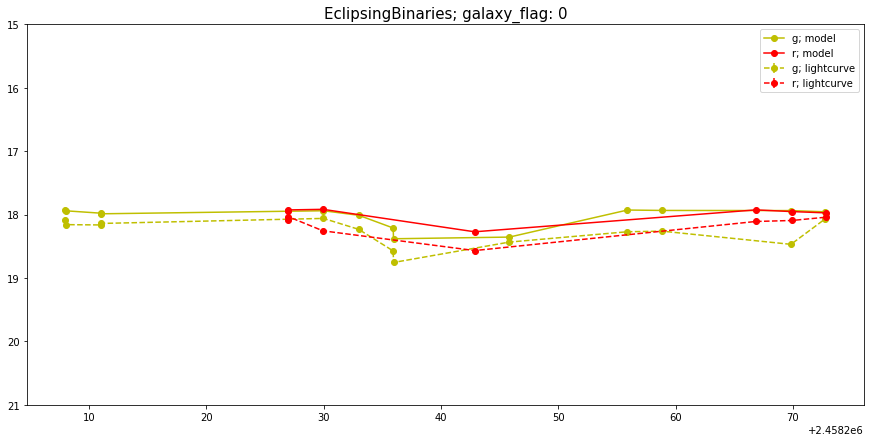

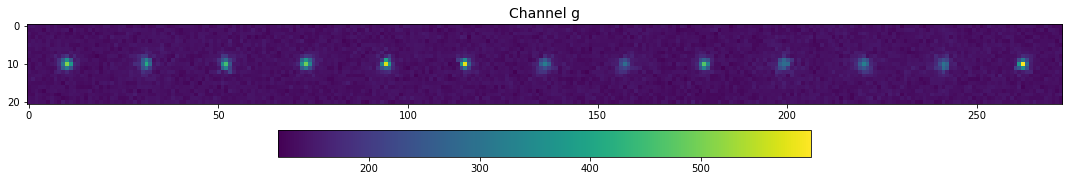

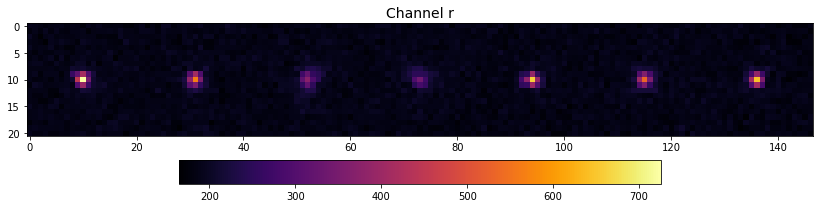


Field12
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 19) r: (60, 21, 21, 22)
lcs g: (60, 19) r: (60, 22)
obs days <HDF5 dataset "g": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 19), type "<f8">
obs days <HDF5 dataset "r": shape (22,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 19), type "<f8">

Field13
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 7) r: (60, 21, 21, 16)
lcs g: (60, 7) r: (60, 16)
obs days <HDF5 dataset "g": shape (7,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 7), type "<f8">
obs days <HDF5 dataset "r": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 7), type "<f8">

Fi

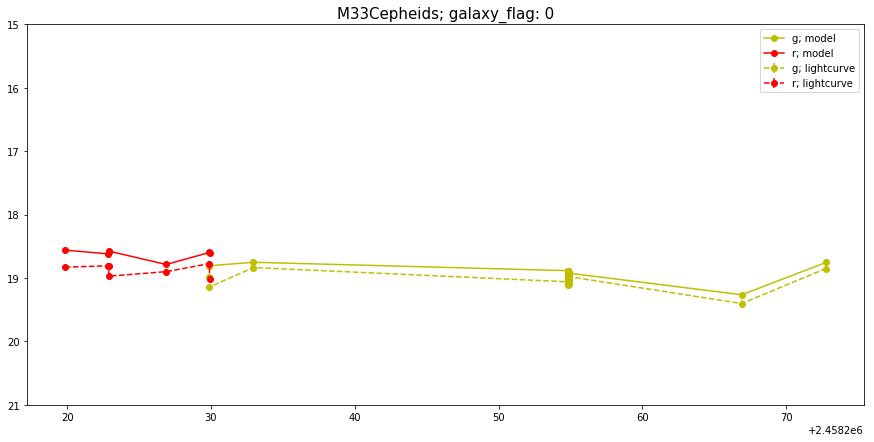

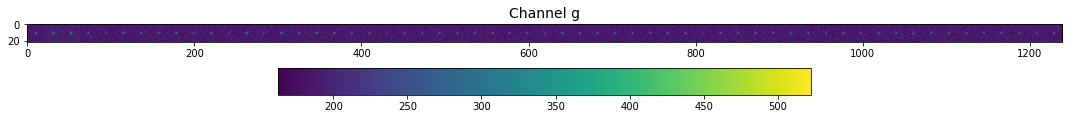

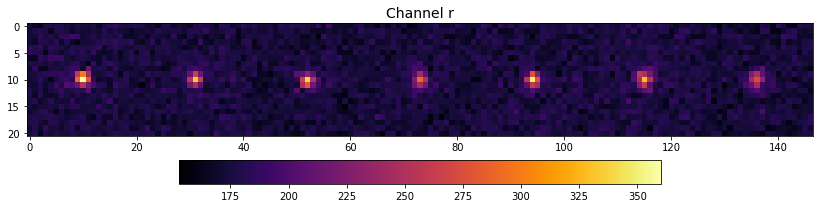


Field18
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 19) r: (60, 21, 21, 1)
lcs g: (60, 19) r: (60, 1)
obs days <HDF5 dataset "g": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 19), type "<f8">
obs days <HDF5 dataset "r": shape (1,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 1), type "<f8">
Field18[15]
[26.26766384 26.48668778 26.74383426 26.50559986 26.82432938 26.60562098
 26.43245637 26.49212325 26.37850797 26.46215427 26.48492551 26.49071634
 26.31731105 26.47176313 26.37844217 26.85250092 26.46425951 26.40413272
 26.40937388]
[26.10881793]


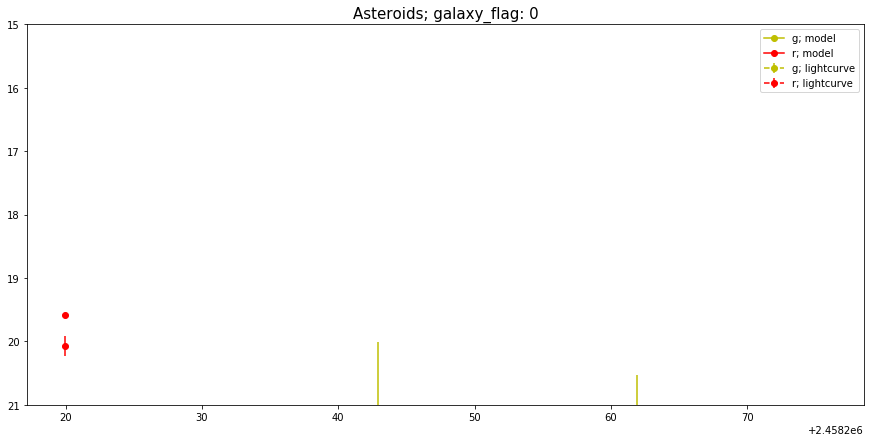

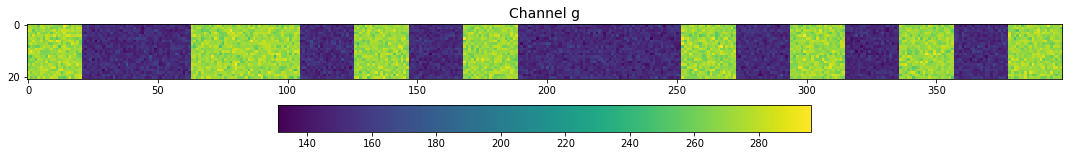

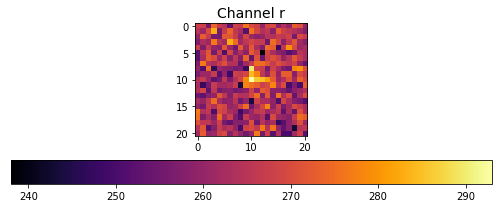


Field19
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 15) r: (60, 21, 21, 9)
lcs g: (60, 15) r: (60, 9)
obs days <HDF5 dataset "g": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 15), type "<f8">
obs days <HDF5 dataset "r": shape (9,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 9), type "<f8">
Field19[13]
[26.51811242 26.0083313  26.31696963 26.24346149 26.28848898 26.26173806
 26.17190552 26.51549351 25.5206039  26.27227604 26.48882055 26.35223424
 26.42667925 26.27912664 26.39844978]
[26.2456404  26.3513521  26.21757495 26.59013319 26.38440669 26.31004024
 26.41533422 26.40334952 26.07977223]


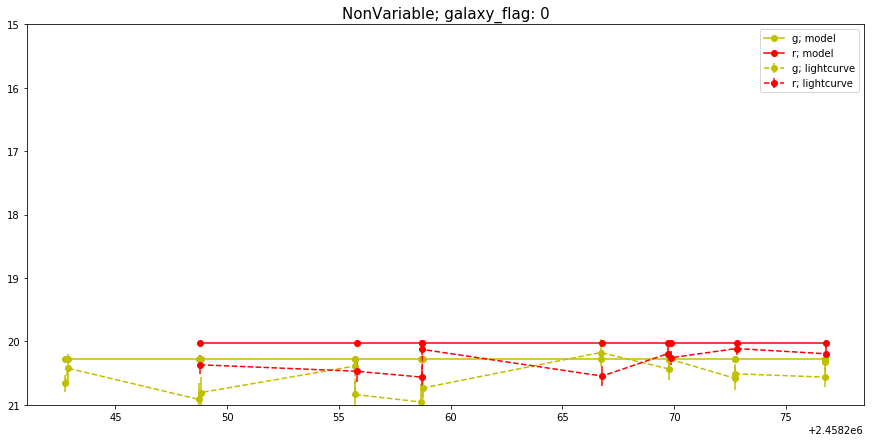

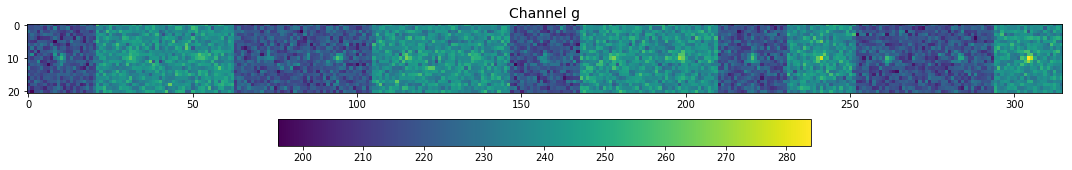

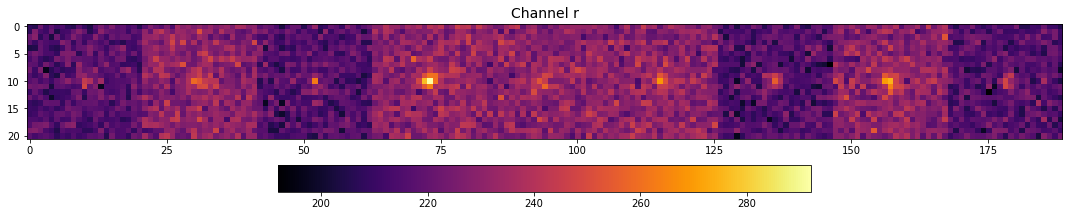


Field20
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 14) r: (60, 21, 21, 16)
lcs g: (60, 14) r: (60, 16)
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 14), type "<f8">

Field21
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 21) r: (60, 21, 21, 15)
lcs g: (60, 21) r: (60, 15)
obs days <HDF5 dataset "g": shape (21,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 21), type "<f8">
obs days <HDF5 dataset "r": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 15), type "<f8"

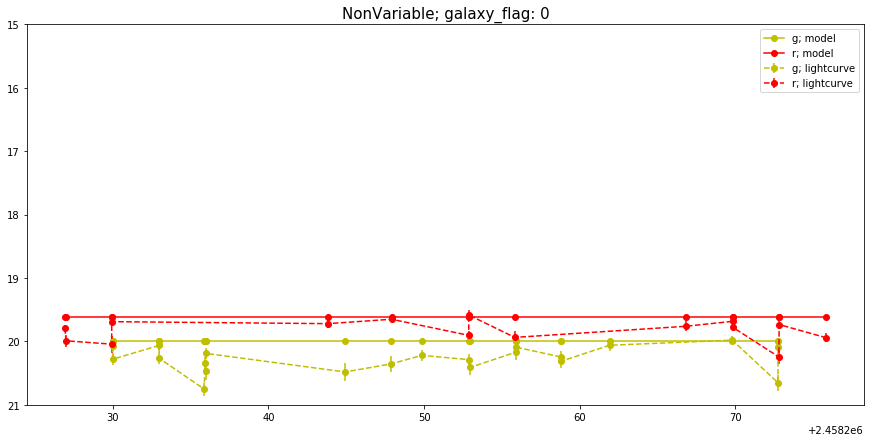

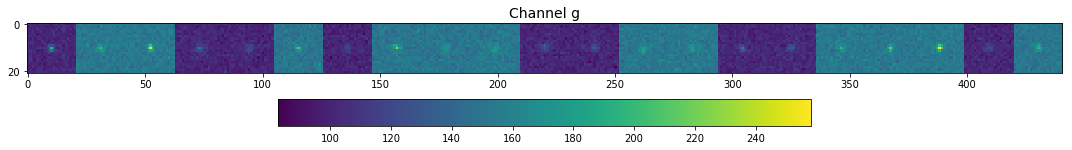

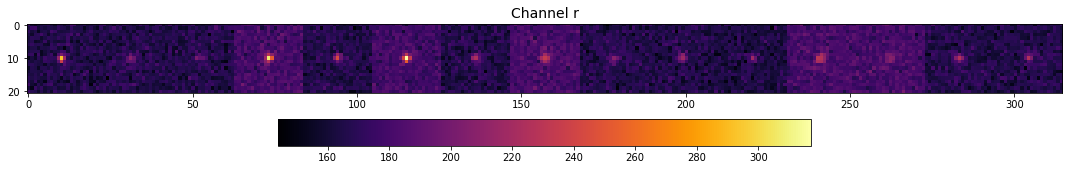


Field22
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 11) r: (60, 21, 21, 13)
lcs g: (60, 11) r: (60, 13)
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">

Field23
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 28) r: (60, 21, 21, 14)
lcs g: (60, 28) r: (60, 14)
obs days <HDF5 dataset "g": shape (28,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 28), type "<f8">
obs days <HDF5 dataset "r": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 14), type "<f8"

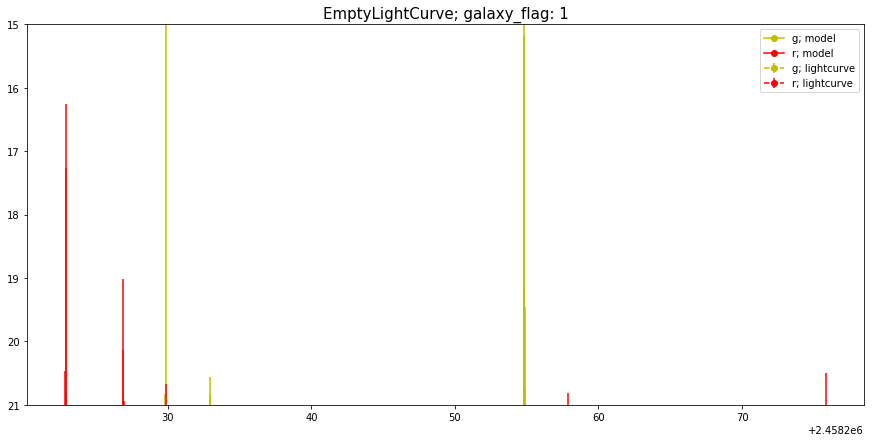

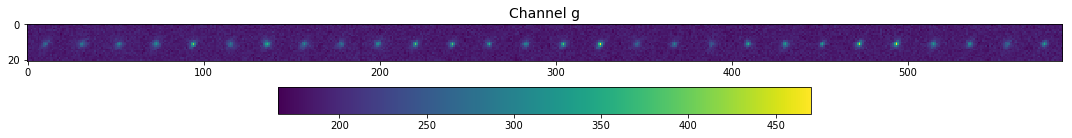

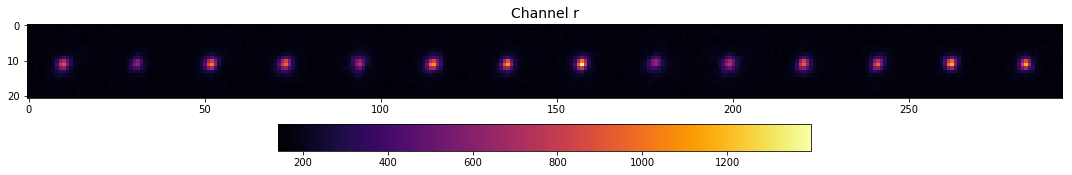


Field24
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 98) r: (60, 21, 21, 2)
lcs g: (60, 98) r: (60, 2)
obs days <HDF5 dataset "g": shape (98,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 98), type "<f8">
obs days <HDF5 dataset "r": shape (2,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 2), type "<f8">
Field24[28]
[26.4942143  26.48628402 26.47987139 26.58285618 26.63062072 26.49703062
 26.4816649  26.47474611 26.45234787 26.44716835 26.41130257 26.42432427
 26.45329177 26.45363688 26.43121672 26.44319105 26.31319416 26.46474993
 26.3889792  26.2553407  26.44112062 26.41899967 26.36310565 26.42255092
 26.48683333 26.36271906 26.3953985  26.41611171 26.41976225 26.38431537
 26.47228241 26.44199395 26.39151013 26.38047659 26.43081117 26.31516612
 26.42001438 26.31833005 26.38174939 26.40225542 26.2

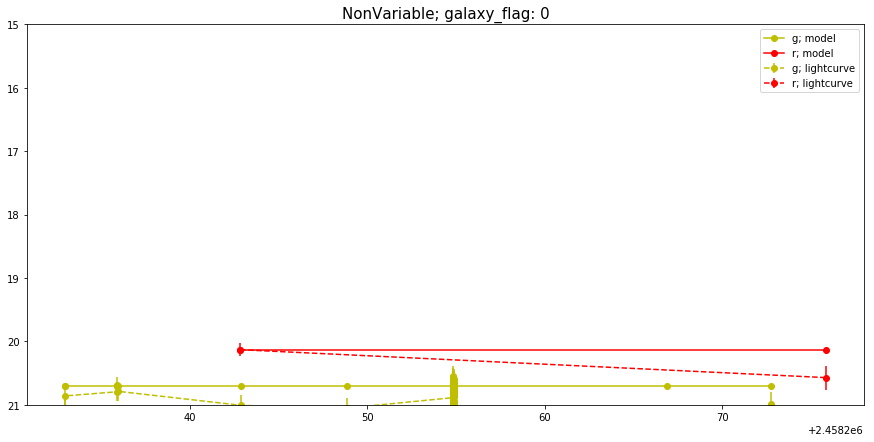

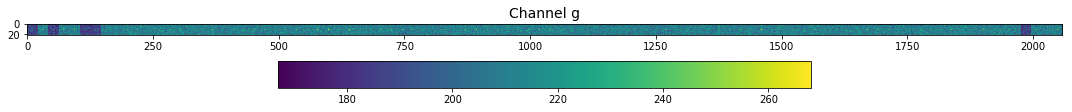

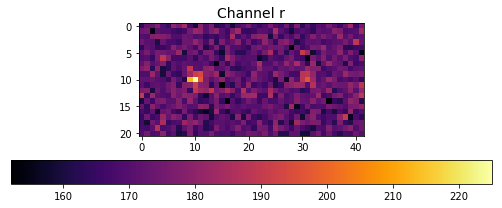


Field25
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 4) r: (60, 21, 21, 20)
lcs g: (60, 4) r: (60, 20)
obs days <HDF5 dataset "g": shape (4,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 4), type "<f8">
obs days <HDF5 dataset "r": shape (20,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 4), type "<f8">

Field26
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 22) r: (60, 21, 21, 19)
lcs g: (60, 22) r: (60, 19)
obs days <HDF5 dataset "g": shape (22,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 22), type "<f8">
obs days <HDF5 dataset "r": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 19), type "<f8">
Fie

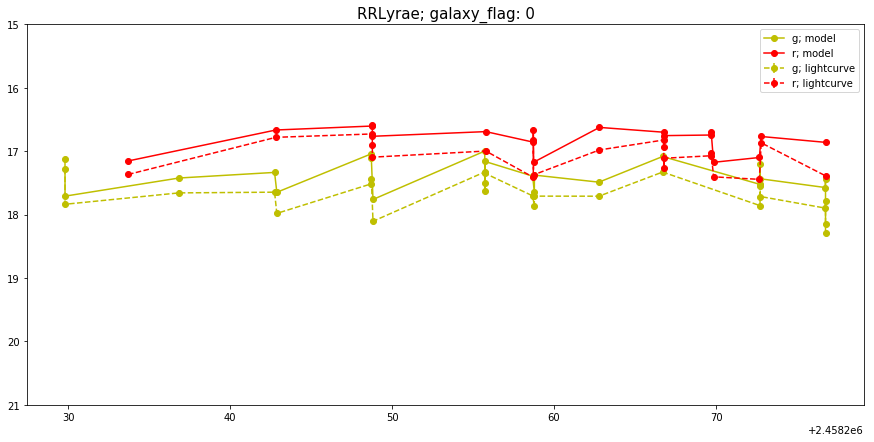

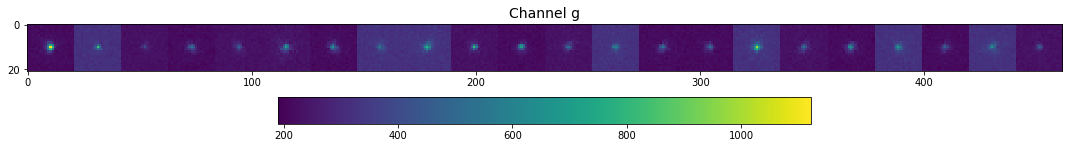

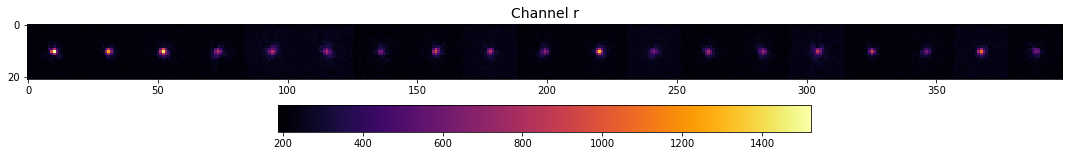


Field27
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 94) r: (60, 21, 21, 5)
lcs g: (60, 94) r: (60, 5)
obs days <HDF5 dataset "g": shape (94,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 94), type "<f8">
obs days <HDF5 dataset "r": shape (5,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 5), type "<f8">
Field27[48]
[26.40240407 26.43388343 26.43183398 26.62855542 25.94761956 25.91159546
 25.77169561 26.14634144 26.10875475 26.1165607  26.08903503 25.74071395
 26.25629175 26.15618062 26.17977905 26.33674288 26.20762527 26.5875771
 25.94169748 26.2672745  26.21850669 25.81584132 26.24989974 26.47249413
 26.42711532 26.13962197 26.39648914 26.2030704  26.37669432 26.49798691
 26.38855159 26.23181379 26.24324679 26.29192781 26.4274025  26.38396502
 26.18799651 26.30153847 26.39617443 26.31348038 26.27

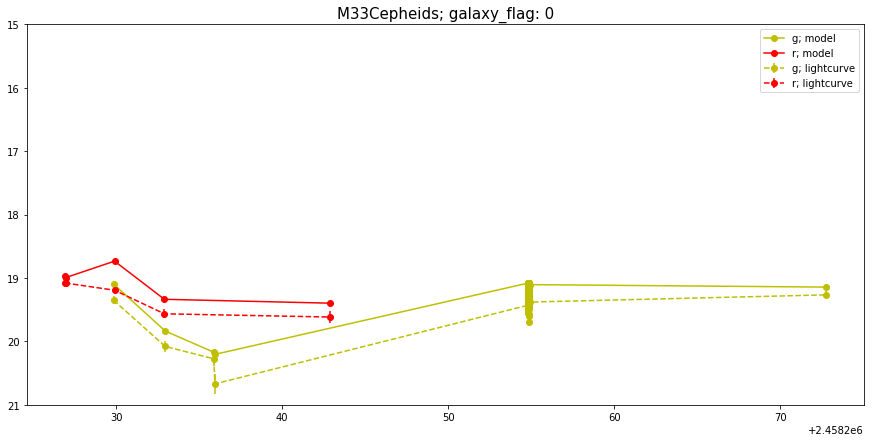

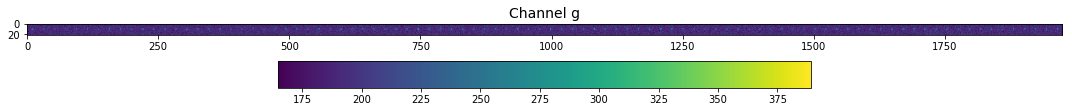

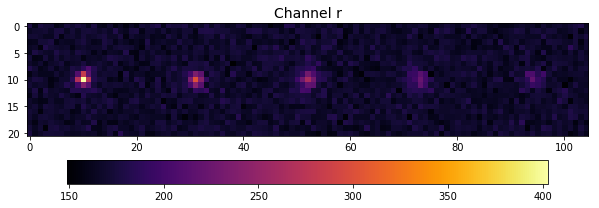


Field28
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 10) r: (60, 21, 21, 10)
lcs g: (60, 10) r: (60, 10)
obs days <HDF5 dataset "g": shape (10,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 10), type "<f8">
obs days <HDF5 dataset "r": shape (10,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 10), type "<f8">
Field28[54]
[26.42658007 26.52938223 26.40922105 26.61228335 26.53185761 26.42843103
 26.26814544 26.2756356  26.32226276 26.42549896]
[26.36154842 26.44749856 26.54209936 26.64966512 26.50530541 26.28039324
 26.24739468 26.42600179 26.3423723  26.32517636]


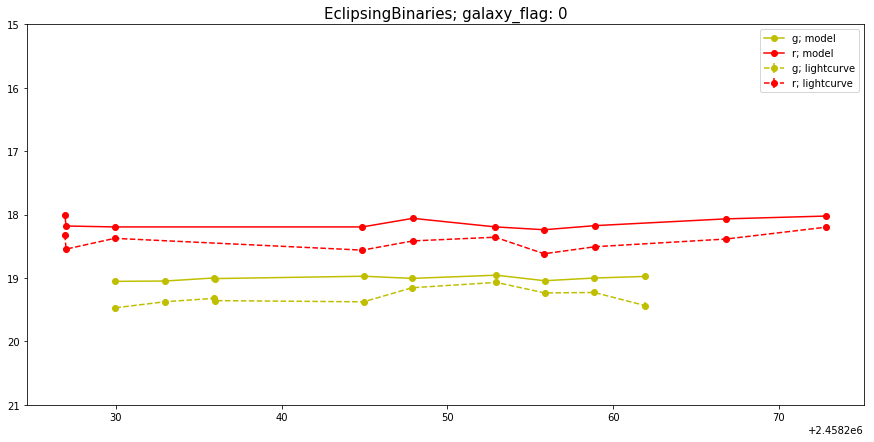

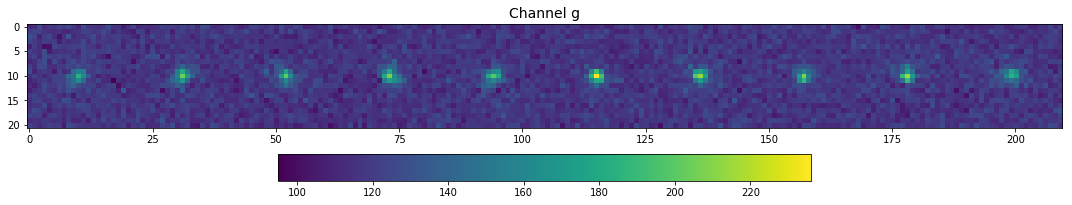

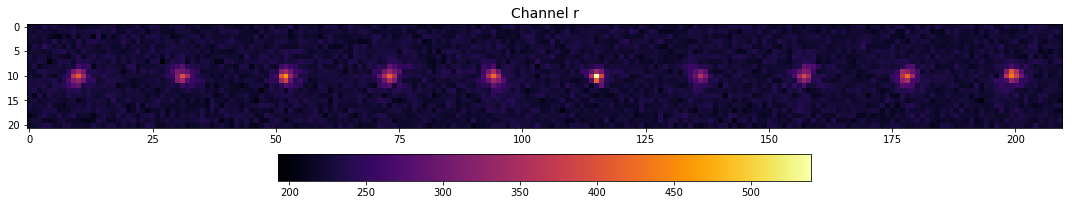


Field29
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 87) r: (60, 21, 21, 2)
lcs g: (60, 87) r: (60, 2)
obs days <HDF5 dataset "g": shape (87,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 87), type "<f8">
obs days <HDF5 dataset "r": shape (2,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 2), type "<f8">
Field29[25]
[26.28939903 26.43145144 26.35690022 26.51399541 26.38891137 26.48855221
 26.46117234 26.44089162 26.36074245 26.31042182 26.2217629  26.4954114
 25.71963429 26.43705571 26.47832024 26.3430599  25.96824074 26.55779898
 26.28204668 25.95087111 26.25560153 26.5331223  26.11406755 26.26524639
 26.4702661  26.19090819 26.13526094 26.40955257 26.48473072 26.03642225
 26.26645446 26.44650006 26.32769835 26.24572957 26.70455921 26.43771219
 26.42805231 26.49750853 26.19538891 26.72561586 26.65

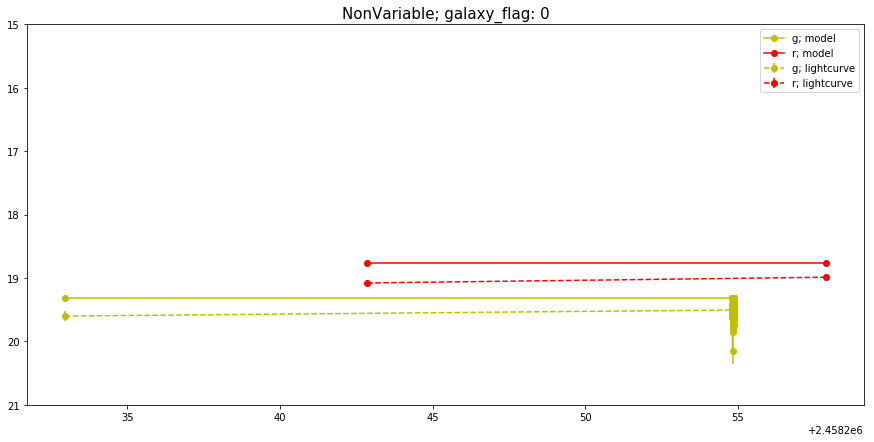

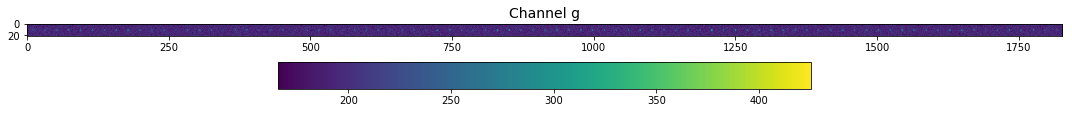

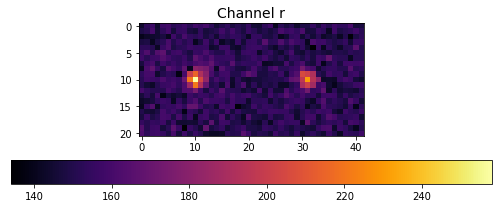


Field30
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 8) r: (60, 21, 21, 13)
lcs g: (60, 8) r: (60, 13)
obs days <HDF5 dataset "g": shape (8,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 8), type "<f8">
obs days <HDF5 dataset "r": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 8), type "<f8">

Field32
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 17) r: (60, 21, 21, 15)
lcs g: (60, 17) r: (60, 15)
obs days <HDF5 dataset "g": shape (17,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 17), type "<f8">
obs days <HDF5 dataset "r": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 15), type "<f8">
Fie

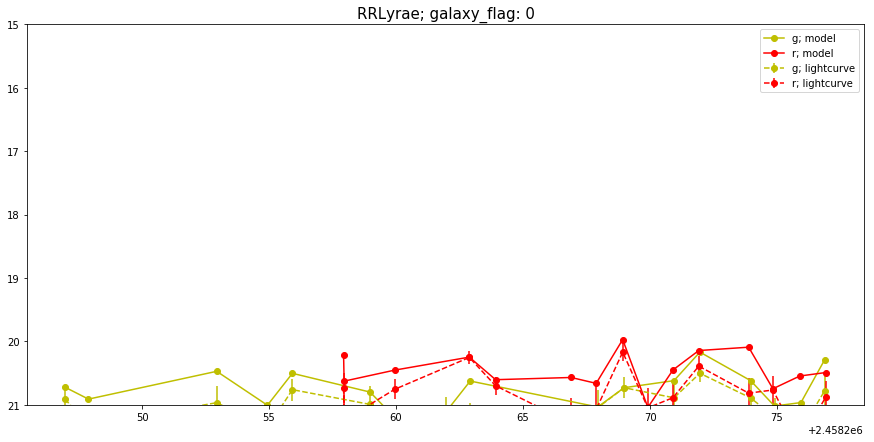

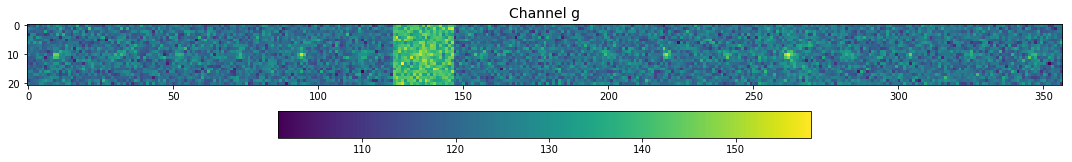

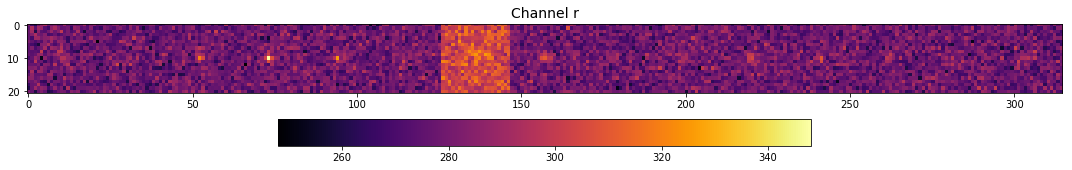


Field33
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 14) r: (60, 21, 21, 7)
lcs g: (60, 14) r: (60, 7)
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (7,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 7), type "<f8">
Field33[29]
[26.57327664 26.81689596 26.44979024 26.18803501 26.28548324 26.53144205
 26.35048807 26.76767087 26.40183663 26.35494494 26.3825556  26.47559249
 26.34078205 26.30795825]
[26.37408149 26.55617654 26.16523504 26.21111715 26.42030811 26.41873157
 26.46660829]


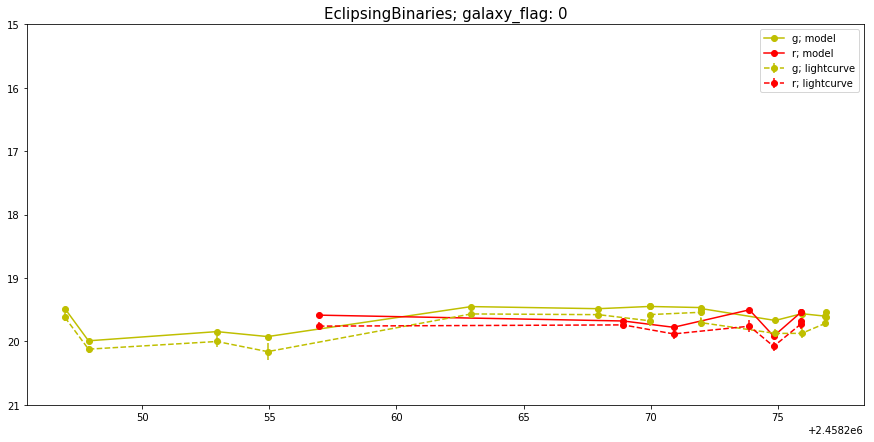

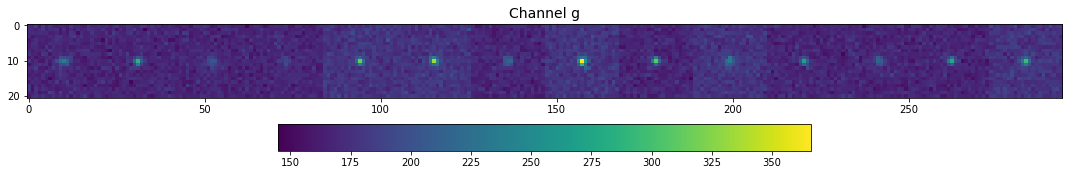

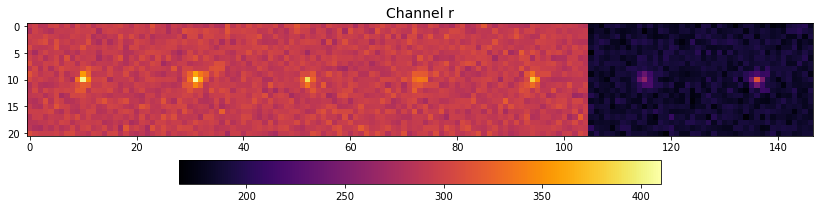


Field34
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 15) r: (60, 21, 21, 10)
lcs g: (60, 15) r: (60, 10)
obs days <HDF5 dataset "g": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 15), type "<f8">
obs days <HDF5 dataset "r": shape (10,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 10), type "<f8">
Field34[45]
[26.36050701 26.40137064 26.36329603 26.33325553 26.32304013 26.35204947
 26.34465313 26.32729292 26.34061539 26.34998119 26.31532168 26.2864188
 26.32227504 26.27787149 26.34510088]
[26.41469705 26.21442127 26.23528099 26.29917967 26.35924125 26.20344496
 26.29286861 26.26007438 26.27268791 26.41502941]


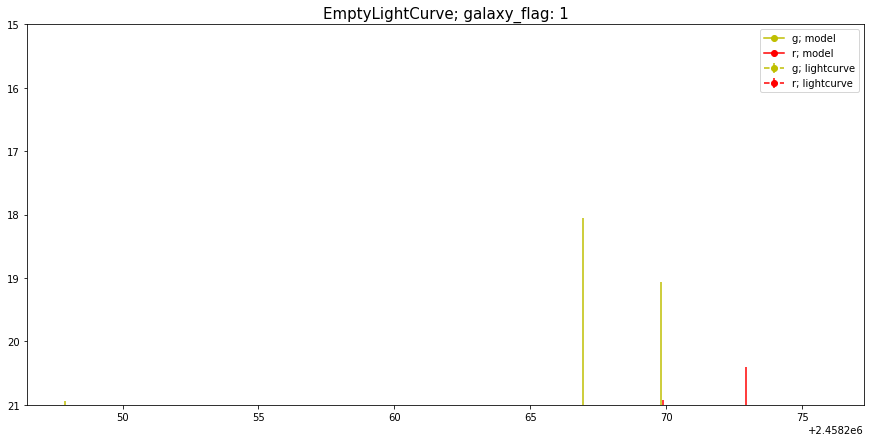

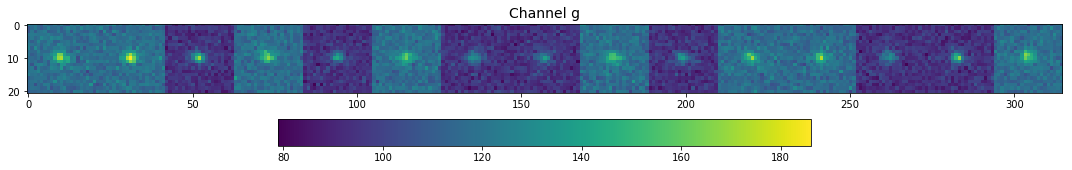

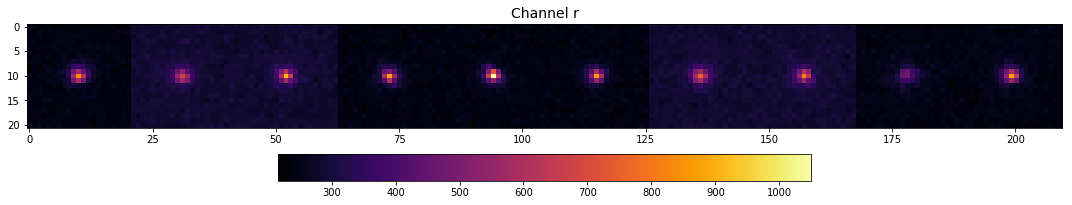


Field35
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 24) r: (60, 21, 21, 1)
lcs g: (60, 24) r: (60, 1)
obs days <HDF5 dataset "g": shape (24,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 24), type "<f8">
obs days <HDF5 dataset "r": shape (1,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 1), type "<f8">
Field35[43]
[26.68938732 26.52690578 26.48582435 26.29025245 26.29838395 23.
 26.21140969 26.3260293  26.10973465 26.36284435 26.37298286 26.44999683
 26.04732919 26.25228453 26.32262433 26.39099061 26.46643519 26.43492973
 26.43313289 26.47676325 26.47602558 26.41819263 26.48050725 26.45797384]
[26.36548877]


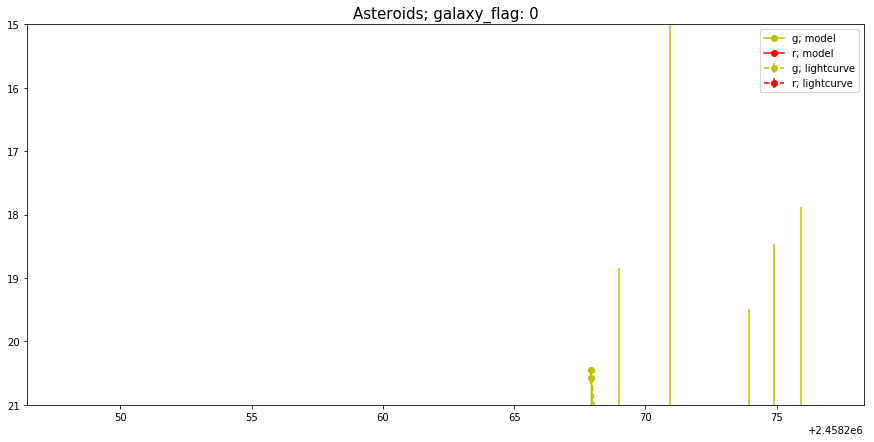

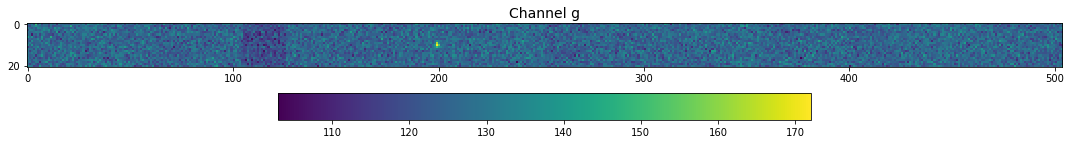

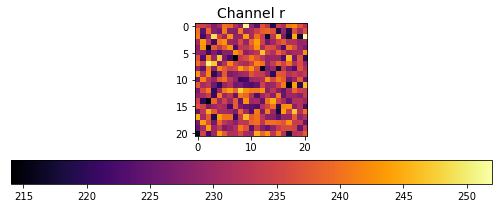


Field36
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 14) r: (60, 21, 21, 12)
lcs g: (60, 14) r: (60, 12)
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (12,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 12), type "<f8">
Field36[0]
[26.35698378 26.42200899 26.32357466 26.42324555 26.34305024 26.15480924
 26.15538681 26.3234098  26.32259834 26.32173443 26.41452336 26.31656921
 26.51518345 26.16477263]
[26.57807791 26.27199304 26.46810126 26.23283422 26.4744668  26.32500422
 26.25768721 26.27502489 26.41624284 26.37192225 26.36899614 26.30203903]


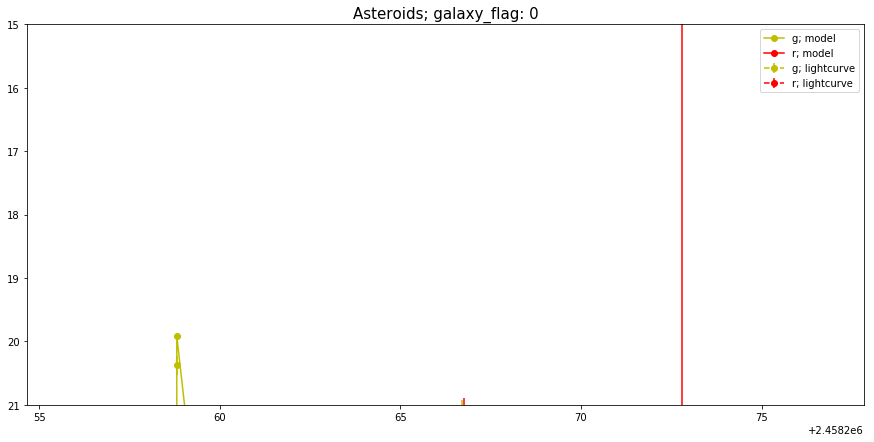

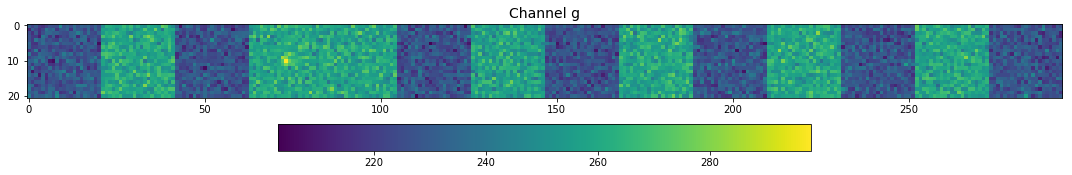

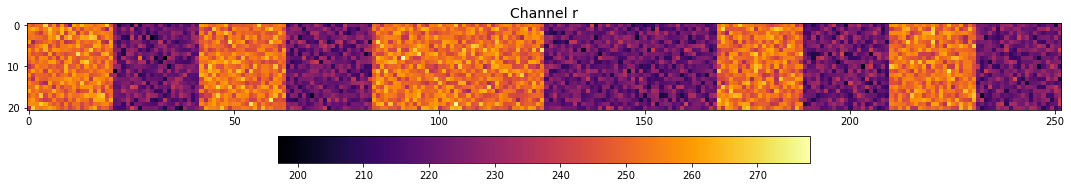


Field38
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 14) r: (60, 21, 21, 11)
lcs g: (60, 14) r: (60, 11)
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">
Field38[45]
[26.38124883 26.34418058 26.35968697 26.37064731 26.31222785 26.33681333
 26.34834254 26.37970221 26.40703857 26.33624279 26.23712921 26.52729595
 26.41175914 26.37368226]
[26.32635486 26.32438695 26.34417093 26.1618644  26.30311561 26.19662821
 26.27098489 26.31268823 26.37081265 26.34335124 26.31154275]


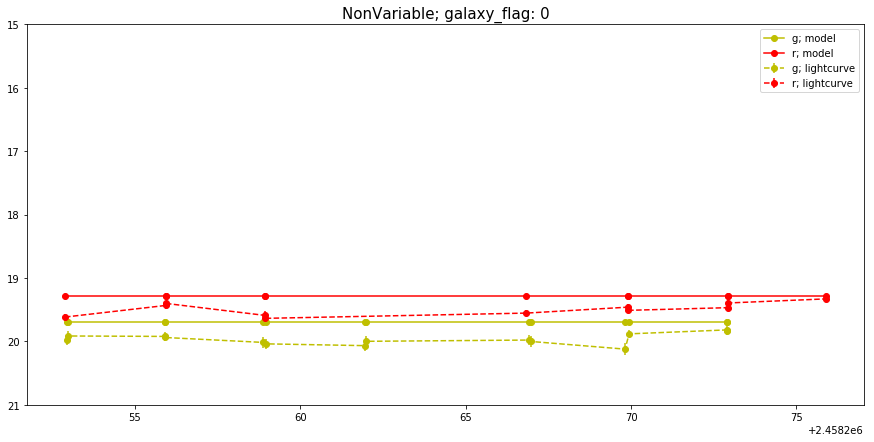

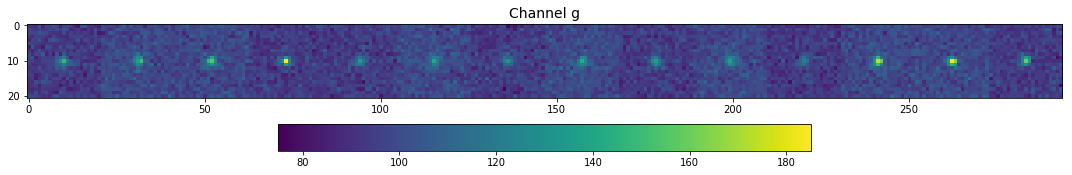

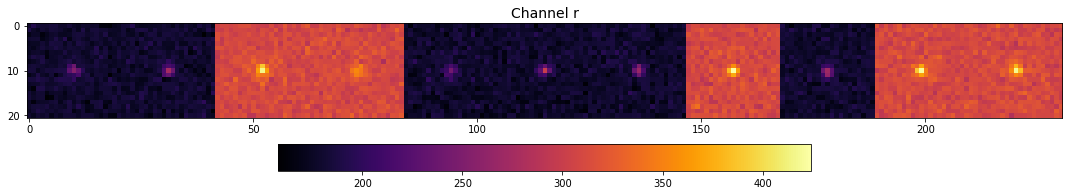


Field39
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 27) r: (60, 21, 21, 16)
lcs g: (60, 27) r: (60, 16)
obs days <HDF5 dataset "g": shape (27,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 27), type "<f8">
obs days <HDF5 dataset "r": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 16), type "<f8">
Field39[54]
[26.4710027  26.27371705 26.08570504 26.40298498 26.00048745 25.81720698
 26.24875557 25.8526808  26.10885775 25.82558322 26.23771608 26.63566828
 26.14095259 25.8124063  26.54019547 26.15755403 26.4939301  26.19825554
 26.38140345 26.32301152 26.28574097 26.29461598 26.29003608 26.37698627
 26.47908413 26.27694499 26.29709172]
[26.28406024 26.30438781 26.30177069 26.29000235 26.28714633 26.29832244
 26.28493738 26.32205462 26.29446721 26.28839517 26.28479099 26.29478669
 26.2913863

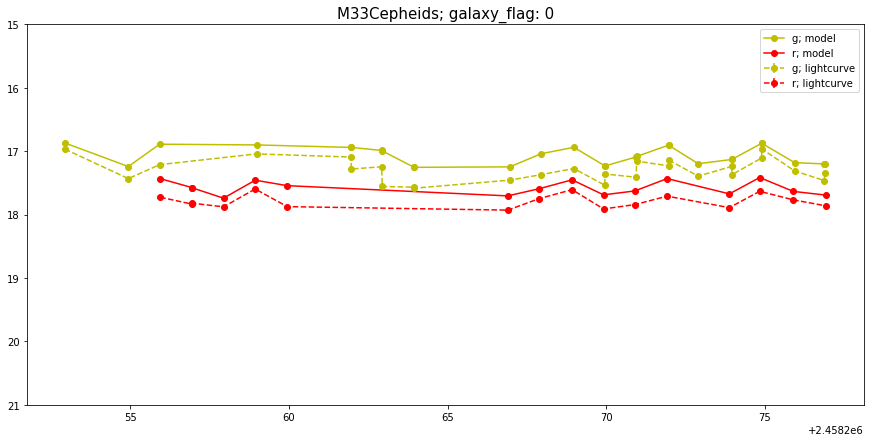

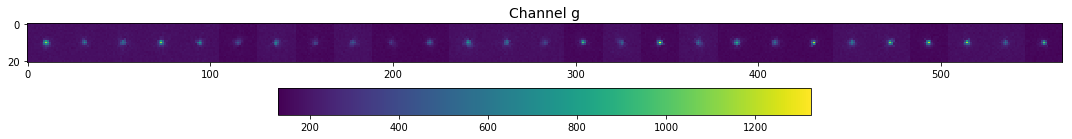

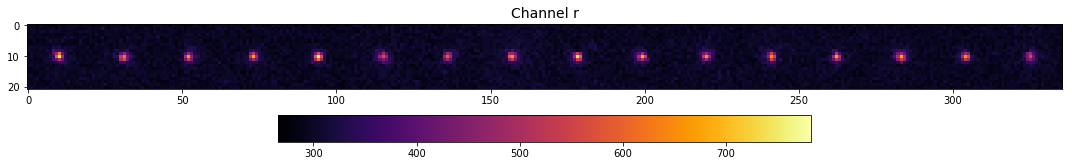


Field40
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 15) r: (60, 21, 21, 8)
lcs g: (60, 15) r: (60, 8)
obs days <HDF5 dataset "g": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 15), type "<f8">
obs days <HDF5 dataset "r": shape (8,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 8), type "<f8">
Field40[18]
[26.51836729 26.48773611 26.1280216  26.35634017 26.08822393 26.31106448
 26.24169886 26.31717205 26.43558347 26.08999443 26.25742698 26.39932621
 26.61739242 26.33131897 26.4911257 ]
[26.22537243 26.31482911 26.31866217 26.30877769 26.3310554  26.33993709
 26.36932194 26.33492279]


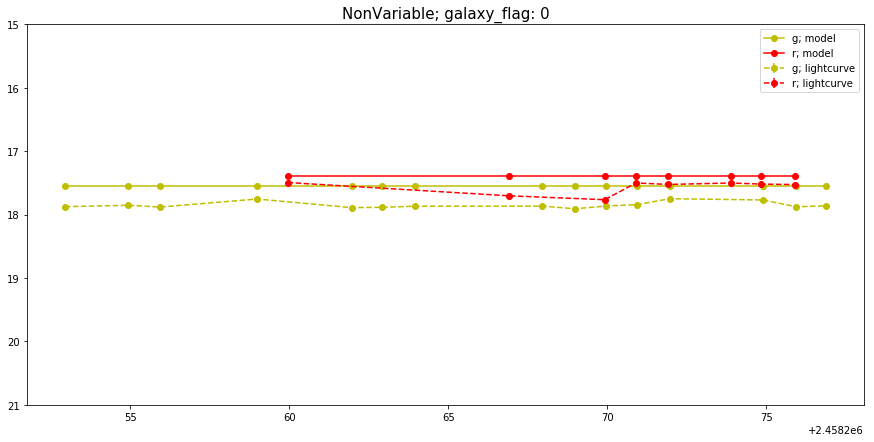

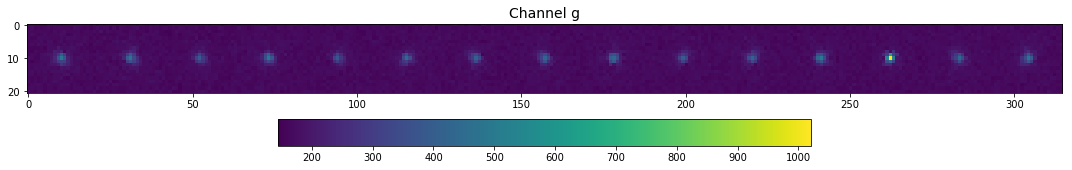

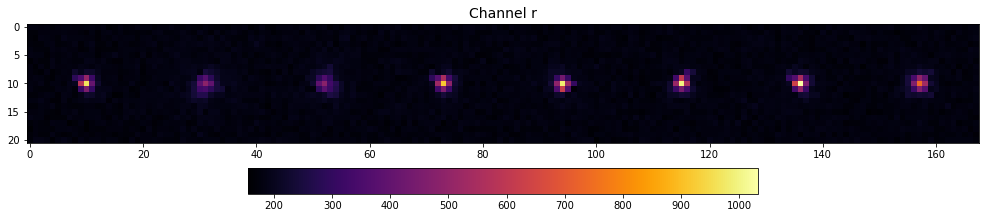


Field41
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 3) r: (60, 21, 21, 23)
lcs g: (60, 3) r: (60, 23)
obs days <HDF5 dataset "g": shape (3,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 3), type "<f8">
obs days <HDF5 dataset "r": shape (23,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 3), type "<f8">

Field43
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
field images g: (60, 21, 21, 11) r: (60, 21, 21, 15)
lcs g: (60, 11) r: (60, 15)
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">

Fi

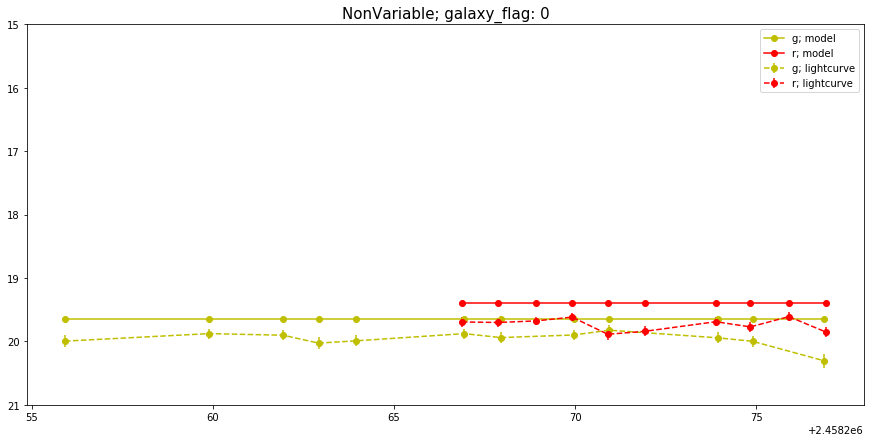

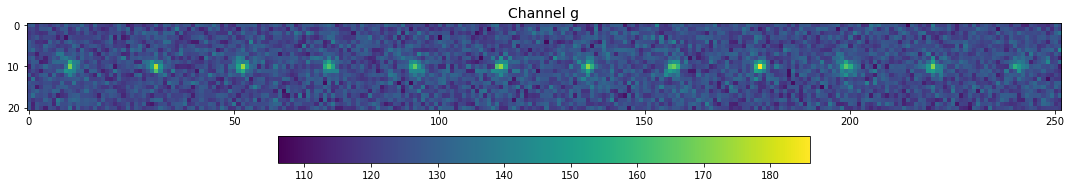

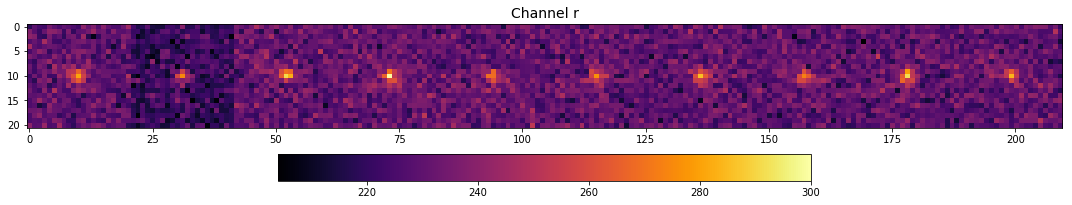

In [10]:
bands = ["g", "r"]
n_per_field = 3
for field in fields:
    print('\n%s' % (field))
    #if field in ['Field01', 'Field03', 'Field04', 'Field08', 'Field12']:
    #    continue
    field_data = f[field]
    print(list(field_data))
    field_images = field_data["images"]
    print("field images g:", field_images["g"].shape, "r:", field_images["r"].shape)
    field_lc = field_data["lightcurves"]
    print("lcs g:", field_lc["g"].shape, "r:", field_lc["r"].shape)
    days = field_data["obs_cond"]["obs_day"]
    #print(field_data["obs_cond"]["sky_brightness"]["r"][:])
    
    for band in bands:
        print('obs days %s' % str(days[band]))
        print('estimated_counts %s' % str(field_data['estimated_counts'][band]))
    if  days[bands[1]].shape[0]!=field_data['estimated_counts'][bands[1]].shape[1]:
        continue
    idx = plot_underliying_and_lc_model(f, field=field)
    lc_type = field_data["lc_type"][idx]
    
    """
    plt.figure(figsize=(15, 7))
    for band in bands:
        plt.plot(days[band], field_lc[band][0, ...], "o-", label=band)
    galaxy_flag = field_data["galaxy_flag"][0]
    plt.title(lc_type+" galaxy_flag", fontsize=15)
    plt.ylim([21, 15])
    plt.legend()
    plt.show()
    """
    for band in bands:
        n_images = field_lc[band].shape[1]
        plt.figure(figsize=(15,3))#3*n_images,3))
        empty_image = np.zeros((21, 21*n_images,))
        for i in range(n_images):
            empty_image[:, i*21:(i+1)*21] = field_images[band][idx, :, :, i]
        if band == "g":
            c_map = "viridis"
        else:
            c_map = "inferno"
        plt.imshow(empty_image, cmap=c_map)
        plt.title('Channel %s' % band, fontsize=14)#np.amin(empty_image))
        plt.colorbar(orientation="horizontal")
        plt.tight_layout()
        plt.show()